In [1]:
# import
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import os

In [2]:
# label
# =========================
def class_2_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    else:
        label = "1"
    return label

# def class_2_type(root):
#     label = ""
#     if "雙踝" in root:
#         label = "0"
#     elif "三踝" in root:
#         label = "1"
#     return label

def class_4_type(root):
    label = ""
    if "0" in root:
        label = "0"
    elif "1" in root:
        label = "1"
    elif "2" in root:
        label = "2"
    else:
        label = "3"
    return label


def class_3_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    elif "雙踝" in root:
        label = "1"
    elif "三踝" in root:
        label = "2"
    return label
# =========================

In [3]:
def load_path(path, class_count):
    dataset = []
    class_type = ''
    if class_count == 2:
        class_type = class_2_type
    elif class_count == 3:
        class_type = class_3_type   
    elif class_count == 4:
        class_type = class_4_type 

    for root, dirs, files in os.walk(path):
        for file in files:
            label = class_type(root)
            if label != "":
                dataset.append(
                                {   
                                    'uuid': root.split("\\")[-1],
                                    'label': label,
                                    'image_path': os.path.join(root, file)
                                }
                            )

    return dataset

In [32]:
def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        weights_vector = tf.reduce_sum(y_true * weights, axis=-1)
        weighted_loss = cross_entropy * weights_vector
        return tf.reduce_mean(weighted_loss)
    return loss

weights = tf.constant([0.5, 1, 1.5])

In [7]:
## 參數設置
image_dir = "E://data_bone//1-swift_cut//front"
# save_path = "./weights/中榮/front/transfer_imagenet/all/"
save_path = ""
class_count = 3
maru_part=None

In [33]:

## load data and  labels
# =========================
data = load_path(image_dir, class_count)
labels = []
filepaths = []
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)
# =========================


## front(AP+Mortise) or side(Lateral) 標籤
# =========================
part = ""
if image_dir.split("//")[-1] == "front":
    part = "AP+Mortise"
else:
    part = "Lateral"
# =========================


# 哪個部位的權重
# =========================
part2="imagenet"
if maru_part is not None:
    part2 = maru_part.split("_")[2]
# =========================

## split image
# =========================
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1, stratify=images['Label'])
print("Training set label distribution:\n", train_df['Label'].value_counts(normalize=False))
print("Test set label distribution:\n", test_df['Label'].value_counts(normalize=False))

# 關閉翻轉
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False,
                                                                    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                                                    validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# =========================


# load model
# =========================
if maru_part is not None:
    pretrained_model = tf.keras.models.load_model(maru_part)
else:
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg')

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu', name='dense_128')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu', name='dense_50')(x)

outputs = tf.keras.layers.Dense(class_count, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
# print(model.summary())
# =========================


## compile and evaluate
# =========================
print("-------Training " + part + part2 + "-------")
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_categorical_crossentropy(weights), metrics=['accuracy'])

## early stop 
# callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## no early stop
history = model.fit(train_images, validation_data=val_images, epochs=25)

results = model.evaluate(test_images, verbose=0)
# =========================


## save model to this path
# =========================
# model.save(save_path + part2 + "_" + part + "_" + str(class_count) + "class" + "_frac.h5")
# model.save(save_path + part2 + "_" + part + "_" + "bi_tri_" + "class" + "_frac.h5")
model.save(save_path + "frac.h5")
# =========================


## print results
# =========================
print(part + "_" + part2 + "_Results:")
pred = model.predict(test_images)
predicted_labels = np.argmax(pred, axis=1)
f1 = f1_score(test_images.labels, predicted_labels, average='macro')
precision = precision_score(test_images.labels, predicted_labels, average='macro')
recall = recall_score(test_images.labels, predicted_labels, average='macro')

print(results)
print(f"Test Accuracy: {np.round(results[1], 2)}")
print(f"f1 score: {np.round(f1, 2)}")
print(f"precision: {np.round(precision, 2)}")
print(f"recall: {np.round(recall, 2)}")
# =========================


# create plots for accuracy and save it
# =========================
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(part + " " + part2 +' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
figAcc = plt.gcf()
# my_file = os.path.join("./plots/" + part + "_" + part2 + "_" + str(class_count) + "class_Accuracy.jpeg")
# my_file = os.path.join("./plots/" + part + "_" + part2 + "_" + "bi_tri_" + "class_Accuracy.jpeg")
my_file = os.path.join("./plots/Accuracy.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


## create plots for loss and save it
# =========================
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(part2 +"_"+ part + ' model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
figAcc = plt.gcf()
# my_file = os.path.join("./plots/" + part + "_" + part2 + "_" + str(class_count) + "class_Loss.jpeg")
# my_file = os.path.join("./plots/" + part + "_" + part2 + "_" + "bi_tri_" + "class_Loss.jpeg")
my_file = os.path.join("./plots/Loss.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


## plot confusion matrix
# =========================
if class_count == 2:
    display_labels = [0, 1]
elif class_count == 3:
    display_labels = [0, 1, 2]
elif class_count == 4:
    display_labels = [0, 1, 2, 3]


cm = confusion_matrix(test_images.labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
cm_display.plot()
plt.title(part2 +"_"+ part + ' Confusion Matrix')
figAcc = plt.gcf()
# my_file = os.path.join("./plots/" + part + "_" + part2 + "_" + str(class_count) + "class_Confusion Matrix.jpeg")
# my_file = os.path.join("./plots/" + part + "_" + part2 + "_" + "bi_tri_" + "class_Confusion Matrix.jpeg")
my_file = os.path.join("./plots/Confusion Matrix.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


Training set label distribution:
 0    145
2     93
1     67
Name: Label, dtype: int64
Test set label distribution:
 0    16
2    11
1     7
Name: Label, dtype: int64
Found 244 validated image filenames belonging to 3 classes.
Found 61 validated image filenames belonging to 3 classes.
Found 34 validated image filenames belonging to 3 classes.
-------Training AP+Mortiseimagenet-------
Epoch 1/25
4/4 [==============================] - 3s 395ms/step - loss: 1.3509 - accuracy: 0.2049 - val_loss: 1.0117 - val_accuracy: 0.2459
Epoch 2/25
4/4 [==============================] - 1s 245ms/step - loss: 0.9838 - accuracy: 0.2951 - val_loss: 1.0374 - val_accuracy: 0.2623
Epoch 3/25
4/4 [==============================] - 1s 224ms/step - loss: 0.9793 - accuracy: 0.3238 - val_loss: 1.0544 - val_accuracy: 0.2623
Epoch 4/25
4/4 [==============================] - 1s 240ms/step - loss: 0.9351 - accuracy: 0.3975 - val_loss: 0.9768 - val_accuracy: 0.4262
Epoch 5/25
4/4 [==============================] - 1s 

d:\anaconda3\envs\bone_20240719\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


AP+Mortise_imagenet_Results:
[0.4950768053531647, 0.7352941036224365]
Test Accuracy: 0.74
f1 score: 0.62
precision: 0.62
recall: 0.64


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
test_df["pred"] = predicted_labels

d:\anaconda3\envs\bone_20240719\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
test_df

,Filepath,Label,pred
233,E://data_bone//1-swift_cut//front\正常\003079891...,0,0
241,E://data_bone//1-swift_cut//front\正常\003081434...,0,0
124,E://data_bone//1-swift_cut//front\正常\000602012...,0,0
274,E://data_bone//1-swift_cut//front\雙踝\000710505...,1,0
324,E://data_bone//1-swift_cut//front\雙踝\002807609...,1,2
175,E://data_bone//1-swift_cut//front\正常\002083898...,0,0
19,E://data_bone//1-swift_cut//front\三踝\000947946...,2,2
129,E://data_bone//1-swift_cut//front\正常\000936387...,0,0
308,E://data_bone//1-swift_cut//front\雙踝\002292629...,1,1
183,E://data_bone//1-swift_cut//front\正常\002438840...,0,0


In [36]:
from keras.preprocessing import image
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out", pred_index=None):
    # 建立一個模型，同時輸出最後一個卷積層和整個模型的預測結果
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # 計算對於輸入圖像的預測類別，相對於最後一個卷積層的梯度
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 輸出分類神經元相對於最後一個卷積層的輸出特徵圖的梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 這是一個向量，其中每個數字都是特定特徵圖通道上的梯度的平均強度
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 將特徵圖乘以權重，等於該特徵圖中的某些區域對於該分類的重要性
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap) # 然後將所有通道相加以獲得熱圖

    # 為了視覺化，將熱圖正規化0~1之間
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # 載入原始圖像
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # 將熱圖重新縮放到0-255的範圍
    heatmap = np.uint8(255 * heatmap)

    # 使用Jet色彩映射將熱圖上色
    jet = cm.get_cmap("Purples")

    # 使用Jet色彩映射的RGB值
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # 創建帶有RGB色彩的熱圖圖像
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # 在原始圖像上疊加熱圖
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)
    plt.axis('off')  # 不顯示坐標軸
    plt.show()

image path=E://data_bone//1-swift_cut//front\雙踝\002807609H_L.jpg


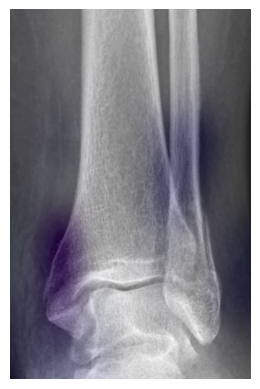

##################################################################################
image path=E://data_bone//1-swift_cut//front\雙踝\000947946D_R.jpg


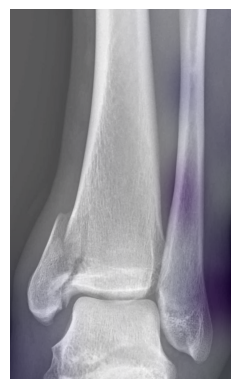

##################################################################################
image path=E://data_bone//1-swift_cut//front\雙踝\001295871D_R.jpg


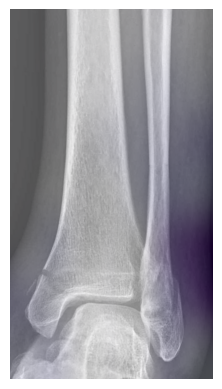

##################################################################################
image path=E://data_bone//1-swift_cut//front\雙踝\000597192G_R.jpg


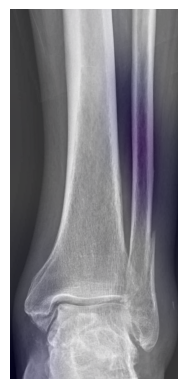

##################################################################################
image path=E://data_bone//1-swift_cut//front\雙踝\002770593H_R.jpg


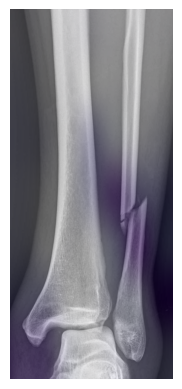

##################################################################################


In [44]:
import matplotlib.image as mpimg
# chosen_model = ".//weights//中榮//front//transfer_imagenet//all//imagenet_AP+Mortise_swift_cut_2class.h5"
chosen_model = "frac.h5"

filtered_df = test_df[(test_df['Label'] == "1") & (test_df['pred'] == 2)]

img = filtered_df["Filepath"].values
for im in img:
    temp_img = image.load_img(im, target_size=(224, 224))
    x = image.img_to_array(temp_img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    heatmap = make_gradcam_heatmap(images, tf.keras.models.load_model(chosen_model, custom_objects={'loss': weighted_categorical_crossentropy(weights)}))
    print(f"image path={im}")
    save_and_display_gradcam(im, heatmap)
    print("##################################################################################")
############################

image path=E://data_bone//1-swift_cut//front//三踝//001744332C_R.jpg


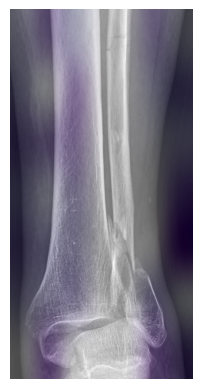

##################################################################################


In [45]:
## 單一查看
import matplotlib.image as mpimg
chosen_model = ".//weights//中榮//front//transfer_imagenet//all//imagenet_AP+Mortise_swift_cut_2class.h5"

im = "E://data_bone//1-swift_cut//front//三踝//001744332C_R.jpg"

temp_img = image.load_img(im, target_size=(224, 224))
x = image.img_to_array(temp_img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
heatmap = make_gradcam_heatmap(images, tf.keras.models.load_model(chosen_model))
print(f"image path={im}")
save_and_display_gradcam(im, heatmap)
print("##################################################################################")
############################